In [8]:
import numpy as np 
import scipy
print(np.__version__)
print(scipy.__version__)
import tqdm
import pandas as pd
import exoplanet
import astropy 
import pymc3
import pymc3_ext
import celerite2
from numpy.linalg import inv, det, solve, cond
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib

1.21.0
1.7.3


## Phase One: White Noise

In [2]:
def partial_mu(t, theta, wrt):
    """
    Unpack parameters and calculate all partial derivatives of the model w.r.t. those parameters
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    - wrt: parameter with respect to which the model's partial derivative is taken
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - derivative vector of length N
    """

    # unpack parameters
    K, P, T0 = theta[0], theta[1], theta[2]
    
    # calculate partial derivative depending on 'wrt'
    normalized_t = t-T0
    arg = (2*np.pi/P) * normalized_t
    
    if wrt=='K':
        return -np.sin(arg)
    elif wrt=='P':
        return -K * np.cos(arg) * arg/P
    elif wrt=='T0':
        return (2*np.pi*K/P) * np.cos(arg)
    
    print("parameter not recognized")
    
    return                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

def calculate_fim(t, factor2, theta):
    """
    Calculate the generalized Fisher Information Matrix according to I_m,n in 
    https://en.wikipedia.org/wiki/Fisher_information#Multivariate_normal_distribution
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma (DEPRECATED): RV measurement uncertainties associated with each observation; np.array of length N [cm/s]; replaced by factor2
    - factor2: inverse covariance matrix; np.array of shape (N, N) [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - Fisher Information Matrix: len(theta)xlen(theta) matrix; np.array
    
    """
    
    fim = np.zeros((len(theta),len(theta)))
    for i in range(len(theta)):
        for j in range(len(theta)):
            wrt_i = param_list[i]
            wrt_j = param_list[j]
            
            factor1 = partial_mu(t, theta, wrt_i)#.reshape((1,4)) # partial derivative of the model wrt row parameter, transposed

            factor3 = partial_mu(t, theta, wrt_j)#.reshape((4,1)) # partial derivative of the model wrt column parameter

            fim[i][j] = factor1 @ factor2 @ factor3 # matrix math magic; thanks to Arvind Gupta for the wisdom
    
    return fim

In [3]:
### priors
param_list = ['K','P','T0']
test_T0 = 2360 # BJD
test_K = 500 # 5 m/s to 500 cm/s; it worked for 10000 cm/s
test_P = 10 # days

test_theta = [test_K, test_P, test_T0]

def make_t(n_obs, cadence, start):
    """
    Gemerate observation times given a number of observations and an average cadence (every X nights)
    
    Input: 
    - n_obs: number of observations to try
    - cadence: amount of time between observations [days]
    - start: start time [BJD]
    
    Output:
    - observation times: ndarray
    
    """
    
    ### make a t using n_obs and cadence
    # initial obs time of 2300 is a placeholder that's set as somewhat close to the arbitrary test_T0 of 2360
    end = start + n_obs * cadence 
    t = np.linspace(2300, end, n_obs, endpoint=False)
    
    # add jitter ~ N(0, 1 hr) to timestamps
    t += np.random.normal(0, 1./24)

    return t

def make_t_without_jitter(n_obs, cadence, start):
    """
    Gemerate observation times given a number of observations and an average cadence (every X nights)
    
    Input: 
    - n_obs: number of observations to try
    - cadence: amount of time between observations [days]
    - start: start time [BJD]
    
    Output:
    - observation times: ndarray
    
    """
    
    ### make a t using n_obs and cadence
    # initial obs time of 2300 is a placeholder that's set as somewhat close to the arbitrary test_T0 of 2360
    end = start + n_obs * cadence 
    t = np.linspace(2300, end, n_obs, endpoint=False)
    
    return t

def strategy(start, n_obs, cadence, theta, sigma_val=None):
    """
    Allows user to try different n_obs and cadences and visualize how that affects the expected RV semi-amplitude uncertainty, sigma_K
    
    Input: 
    - start: start time from which I build out n_obs * cadence
    - n_obs: number of observations to try
    - cadence: amount of time between observations [days]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    - sigma_val: RV measurement uncertainties associated with each observation; float64 [cm/s]
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - sigma_ks: array of sigma_k's calculated by np.linalg.inv [cm/s]
    - sigma_ks_stable: array of sigma_k's calculated by 1/np.sqrt(FIM[0][0])
    
    """
    
    ### make a t using n_obs and cadence
    # initial obs time of 2300 is a placeholder that's set as somewhat close to the arbitrary test_T0 of 2360
    t = make_t(n_obs, cadence, start)
    #print("time steps: ", t)
    
    ### make covariance matrix in the scalar, white noise case
    if sigma_val != None:
        sigma_val += 1e-6 # perturb sigma_val to guard against numerical instabilities
        sigma = np.diag(np.ones(len(t))) * sigma_val**2 # covariance matrix of scalar sigma_RV's
        sigma = np.linalg.solve(sigma, np.identity(len(sigma))) # invert to make factor2 for FIM
        
        fim = calculate_fim(t, sigma, theta)
        #print("FIM: ", fim)
        #print("det: ", det(fim))
        inv_fim = inv(fim)
        #print("inv: ", inv_fim)
        sigma_k = np.sqrt(inv_fim)[0][0]
        #print("sigma_K, using inv: ", sigma_k)
        #sigma_ks.append(sigma_k)
        sigma_k_stable = np.sqrt(1/fim[0][0])
        #print("sigma_K, not using inv: ", sigma_k_stable)

        # np.linalg.solve is more stable than np.linalg.inv, apparently
        inv_fim_solve = solve(fim, np.diag(np.ones(len(theta)))) 
        sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]
        
        return sigma_k, sigma_k_stable, sigma_k_solve, fim
    
    ### make covariance matrix in the correlated noise case
    else:
        sigma = cov_matrix(t, params)
        sigma += 1e-6 
        
        fim = calculate_fim(t, sigma, theta)
        inv_fim = inv(fim)
        sigma_k = np.sqrt(inv_fim)[0][0]
        sigma_k_stable = np.sqrt(1/fim[0][0])
        inv_fim_solve = solve(fim, np.diag(np.ones(len(theta)))) 
        sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]
        
        return sigma_k, sigma_k_stable, sigma_k_solve, fim

print(strategy(start=2352, n_obs=100, cadence=1, theta=test_theta, sigma_val=30)) # default to 2300



(4.266991622268834, 4.26689483269794, 4.266991622268834, array([[ 5.49257660e-02, -4.06721475e-01, -4.68982933e-02],
       [-4.06721475e-01,  1.22058609e+05, -8.45619985e+03],
       [-4.68982933e-02, -8.45619985e+03,  5.54527056e+03]]))


#### Let's generate lots of different strategies using a variety of combinations of n_obs and cadences. 

In [4]:
# priors
param_list = ['K','P','T0']
test_T0 = 2360 # BJD
test_K = 500 # 5 m/s to 500 cm/s; it worked for 10000 cm/s
test_P = 10 # days
test_theta = [test_K, test_P, test_T0]

dim = 100

### try different numbers of total observations made
n_observations = np.linspace(3, 102, dim).astype(int)

### try different observing cadences
### lower bound
# Arjun Savel (thanks, Arjun!) says that 0.6 days is generally considered the minimum (why?)
# Nyquist sampling says halve that to 0.3 days
# Nyquist sampling says the minimum number of observations you need to confirm periodicity is 2
# See wikipedia page for 'Nyquist rate'

### upper bound
# TESS planets generally have max period of 13.7 days
# again, due to Nyquist, halve it to 6.85 days
cadences = np.linspace(0.30, 6.85, dim)

#with tqdm.tqdm(total=100) as pbar:
starts = np.linspace(2300, 2300+test_P, 200)
sigma_ks_all = np.ones(dim**2).reshape((dim,dim))
sigma_ks_stable_all = np.ones(dim**2).reshape((dim,dim))
sigma_ks_solve_all = np.ones(dim**2).reshape((dim,dim))
    
for start in starts: 
    sigma_ks = np.ones(dim**2).reshape((dim,dim))
    sigma_ks_stable = np.ones(dim**2).reshape((dim,dim))
    sigma_ks_solve = np.ones(dim**2).reshape((dim,dim))

    for enum_i, i in enumerate(n_observations):
        for enum_j, j in enumerate(cadences):
            try:
                sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=start, n_obs=i, cadence=j, theta=test_theta, sigma_val=30)
            except Exception as e:
                print(e, ", culprit: ", start, i, j)

            sigma_ks[enum_i][enum_j] = sigma_k
            sigma_ks_stable[enum_i][enum_j] = sigma_k_stable
            sigma_ks_solve[enum_i][enum_j] = sigma_k_solve

            sigma_ks_all += sigma_ks
            sigma_ks_stable_all += sigma_ks_stable
            sigma_ks_solve_all += sigma_ks_solve

/tmp/ipykernel_553850/100179410.py:92: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_553850/100179410.py:100: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


Singular matrix , culprit:  2300.0502512562816 20 4.997474747474747
Singular matrix , culprit:  2303.0150753768844 15 4.798989898989898
Singular matrix , culprit:  2303.21608040201 16 4.798989898989898
Singular matrix , culprit:  2303.4170854271356 17 4.798989898989898
Singular matrix , culprit:  2303.819095477387 19 4.798989898989898
Singular matrix , culprit:  2304.221105527638 21 4.798989898989898
Singular matrix , culprit:  2304.6231155778896 23 4.798989898989898
Singular matrix , culprit:  2305.2261306532664 26 4.798989898989898
Singular matrix , culprit:  2306.2311557788944 31 4.798989898989898
Singular matrix , culprit:  2306.834170854271 34 4.798989898989898
Singular matrix , culprit:  2307.4371859296484 37 4.798989898989898
Singular matrix , culprit:  2307.8391959798996 39 4.798989898989898
Singular matrix , culprit:  2308.040201005025 40 4.798989898989898
Singular matrix , culprit:  2309.145728643216 6 3.4757575757575756
Singular matrix , culprit:  2309.64824120603 48 4.79898

In [7]:
sigma_ks_stable.shape

(100, 100)

In [8]:
n_observations

array([  3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 101, 102])

In [9]:
cadences

array([0.3       , 0.36616162, 0.43232323, 0.49848485, 0.56464646,
       0.63080808, 0.6969697 , 0.76313131, 0.82929293, 0.89545455,
       0.96161616, 1.02777778, 1.09393939, 1.16010101, 1.22626263,
       1.29242424, 1.35858586, 1.42474747, 1.49090909, 1.55707071,
       1.62323232, 1.68939394, 1.75555556, 1.82171717, 1.88787879,
       1.9540404 , 2.02020202, 2.08636364, 2.15252525, 2.21868687,
       2.28484848, 2.3510101 , 2.41717172, 2.48333333, 2.54949495,
       2.61565657, 2.68181818, 2.7479798 , 2.81414141, 2.88030303,
       2.94646465, 3.01262626, 3.07878788, 3.14494949, 3.21111111,
       3.27727273, 3.34343434, 3.40959596, 3.47575758, 3.54191919,
       3.60808081, 3.67424242, 3.74040404, 3.80656566, 3.87272727,
       3.93888889, 4.00505051, 4.07121212, 4.13737374, 4.20353535,
       4.26969697, 4.33585859, 4.4020202 , 4.46818182, 4.53434343,
       4.60050505, 4.66666667, 4.73282828, 4.7989899 , 4.86515152,
       4.93131313, 4.99747475, 5.06363636, 5.12979798, 5.19595

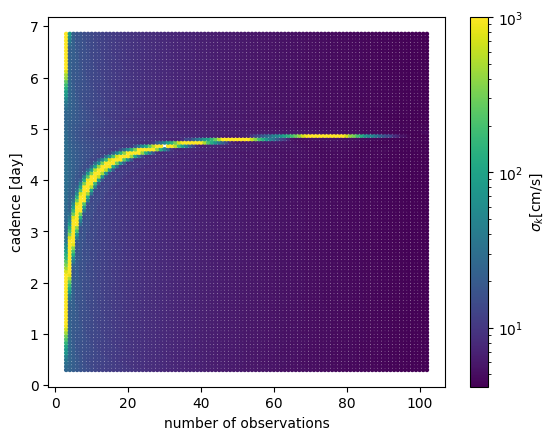

In [7]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks.T, s=5, norm=matplotlib.colors.LogNorm(vmax=1e3))
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$[cm/s]")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
#plt.savefig("plots/n_obs-cadence-sigma_k.pdf", format="pdf")
plt.show()

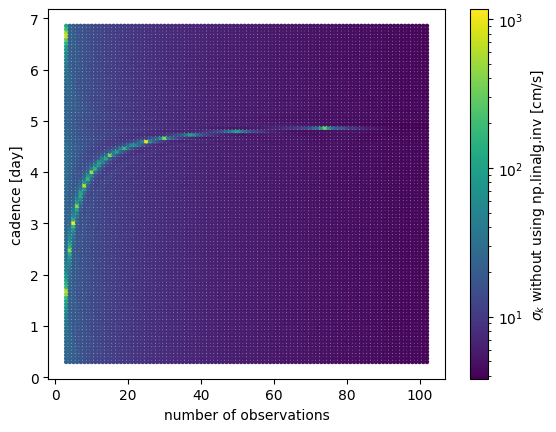

In [6]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks_stable.T, s=5, norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$ without using np.linalg.inv [cm/s]")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
#plt.savefig("plots/n_obs-cadence-sigma_k-stable.pdf", format="pdf")
plt.show()

### Are these yellow bands and dots products of bugs or actual indicators of aliasing? 

a) Let's plot a model and see how the "yellow" strategy observations fall compared to the time series, versus a "purple" strategy. 

b) Let's marginalize over all start times (what  would that range look like?) and stack the images on top of each other. I should expect the yellow artifacts to smooth out.

c) After doing a), let's also add stochasticity to the sampling of the RV observations. That is, do np.linspace()+noise term drawn from a Gaussian with spread of 1 hour. 

#### a) Are my observations actually aliasing my fake RV time series? 

In [4]:
def model(t, theta): 
    """
    Radial velocity model, given timestamps and planetary orbital parameters
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]

    """
    
    K, P, T0 = theta[0], theta[1], theta[2]
    arg = (2*np.pi/P)*(t-T0)
    rv = -K * np.sin(arg)
    
    return rv

/tmp/ipykernel_512569/3869568516.py:71: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_512569/3869568516.py:79: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


FIM:  [[6.87368739e-03 5.26729867e-01 1.73257502e-01]
 [5.26729867e-01 1.29504654e+04 2.92994175e+03]
 [1.73257502e-01 2.92994175e+03 7.47203677e+02]]
sigma_k using linalg.inv:  12.11114459547381
sigma_k using linalg.solve:  12.11114459547381
sigma_k using 1/sqrt(FIM_ii):  12.061605272628283


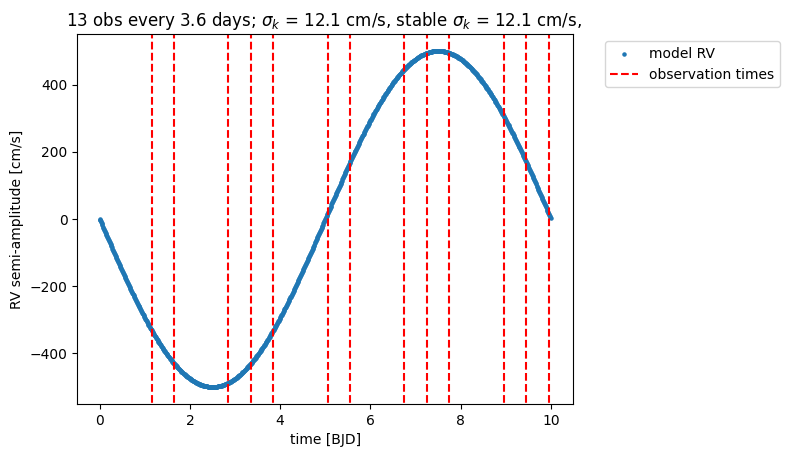

In [9]:
### strategy
cadence = 3.6
n_obs = 13

sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=n_obs, cadence=cadence, theta=test_theta, sigma_val=30)
print("FIM: ", fim)
print("sigma_k using linalg.inv: ", sigma_k)
print("sigma_k using linalg.solve: ", sigma_k_solve)
print("sigma_k using 1/sqrt(FIM_ii): ", sigma_k_stable)
      
### RV model
start = 2300 # BJD
end = 2400 # BJD
test_t = np.linspace(start, end, 1000) + np.random.normal(0, 1./24)
test_t_phase_folded = test_t % test_P
sigma_val = 30+1e-6 # cm/s
test_sigma = np.ones(len(test_t))*sigma_val
y = model(test_t, test_theta)
y_phase_folded = model(test_t_phase_folded, test_theta)

### plot observations from strategy
end = start + cadence * n_obs
strat = np.linspace(2300, end, n_obs) + np.random.normal(0, 1./24)
strat_phase_folded = strat % test_P

plt.scatter(test_t_phase_folded, y_phase_folded, s=5, label='model RV')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'{n_obs} obs every {cadence} days; ' + r'${\sigma}_k$' + f' = {np.round(sigma_k, 1)} cm/s, ' + r'stable ${\sigma}_k$' + f' = {np.round(sigma_k_stable, 1)} cm/s, ')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#plt.savefig('plots/strategy1.pdf', format='pdf')
plt.show()

/tmp/ipykernel_512569/3869568516.py:71: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_512569/3869568516.py:79: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


FIM:  [[ 3.94408433e-02 -5.16501787e-01  2.31602509e-03]
 [-5.16501787e-01  4.36113286e+04  1.65225449e+03]
 [ 2.31602509e-03  1.65225449e+03  3.89336552e+03]]
sigma_k using linalg.inv:  5.03571651040567
sigma_k using linalg.solve:  5.03571651040567
sigma_k using 1/sqrt(FIM_ii):  5.035318006066763


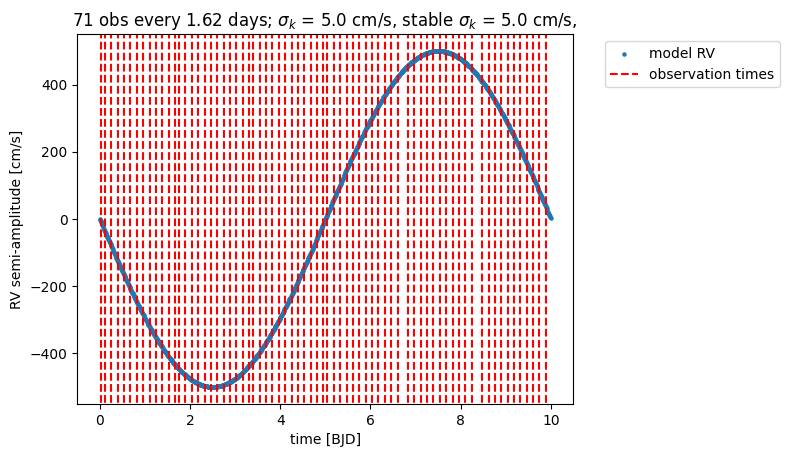

In [10]:
### strategy
cadence = 1.62
n_obs = 71

sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=n_obs, cadence=cadence, theta=test_theta, sigma_val=30)
print("FIM: ", fim)
print("sigma_k using linalg.inv: ", sigma_k)
print("sigma_k using linalg.solve: ", sigma_k_solve)
print("sigma_k using 1/sqrt(FIM_ii): ", sigma_k_stable)
      
### RV model
start = 2300 # BJD
end = 2400 # BJD
test_t = np.linspace(start, end, 1000) + np.random.normal(0, 1./24)
test_t_phase_folded = test_t % test_P
sigma_val = 30+1e-6 # cm/s
test_sigma = np.ones(len(test_t))*sigma_val
y = model(test_t, test_theta)
y_phase_folded = model(test_t_phase_folded, test_theta)

### plot observations from strategy
end = start + cadence * n_obs
strat = np.linspace(2300, end, n_obs) + np.random.normal(0, 1./24)
strat_phase_folded = strat % test_P

plt.scatter(test_t_phase_folded, y_phase_folded, s=5, label='model RV')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'{n_obs} obs every {cadence} days; ' + r'${\sigma}_k$' + f' = {np.round(sigma_k, 1)} cm/s, ' + r'stable ${\sigma}_k$' + f' = {np.round(sigma_k_stable, 1)} cm/s, ')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#plt.savefig('plots/strategy2.pdf', format='pdf')
plt.show()

/tmp/ipykernel_512569/3869568516.py:71: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_512569/3869568516.py:79: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


FIM:  [[ 4.02964992e-02  2.26708835e-01 -1.62958337e-01]
 [ 2.26708835e-01  4.76833732e+04  8.11209739e+02]
 [-1.62958337e-01  8.11209739e+02  4.02824020e+03]]
sigma_k using linalg.inv:  4.9820663539378245
sigma_k using linalg.solve:  4.9820663539378245
sigma_k using 1/sqrt(FIM_ii):  4.9815711898420805


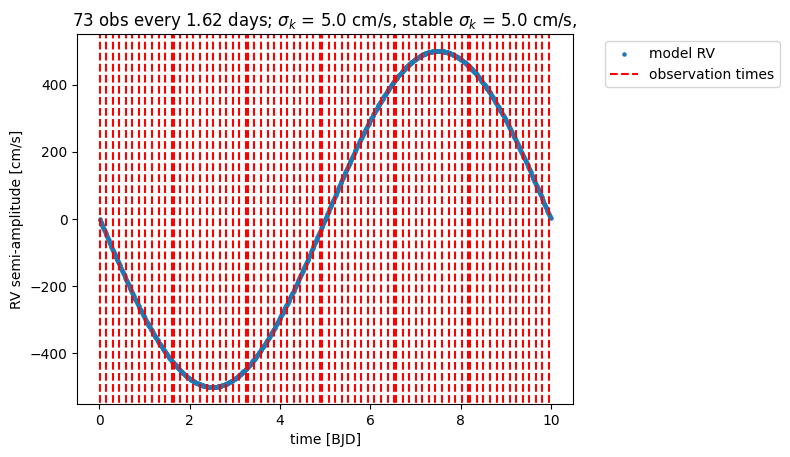

In [11]:
### strategy
cadence = 1.62
n_obs = 73

sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=n_obs, cadence=cadence, theta=test_theta, sigma_val=30)
print("FIM: ", fim)
print("sigma_k using linalg.inv: ", sigma_k)
print("sigma_k using linalg.solve: ", sigma_k_solve)
print("sigma_k using 1/sqrt(FIM_ii): ", sigma_k_stable)
      
### RV model
start = 2300 # BJD
end = 2400 # BJD
test_t = np.linspace(start, end, 1000) + np.random.normal(0, 1./24)
test_t_phase_folded = test_t % test_P
sigma_val = 30+1e-6 # cm/s
test_sigma = np.ones(len(test_t))*sigma_val
y = model(test_t, test_theta)
y_phase_folded = model(test_t_phase_folded, test_theta)

### plot observations from strategy
end = start + cadence * n_obs
strat = np.linspace(2300, end, n_obs) + np.random.normal(0, 1./24)
strat_phase_folded = strat % test_P

plt.scatter(test_t_phase_folded, y_phase_folded, s=5, label='model RV')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'{n_obs} obs every {cadence} days; ' + r'${\sigma}_k$' + f' = {np.round(sigma_k, 1)} cm/s, ' + r'stable ${\sigma}_k$' + f' = {np.round(sigma_k_stable, 1)} cm/s, ')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#plt.savefig('plots/strategy3.pdf', format='pdf')
plt.show()

/tmp/ipykernel_512569/3869568516.py:71: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_512569/3869568516.py:79: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


FIM:  [[ 3.96829802e-02  6.96949463e+01  2.25629440e-03]
 [ 6.96949463e+01  1.27386706e+06 -4.82209145e+04]
 [ 2.25629440e-03 -4.82209145e+04  4.08879210e+03]]
sigma_k using linalg.inv:  5.522457267215733
sigma_k using linalg.solve:  5.522457267215733
sigma_k using 1/sqrt(FIM_ii):  5.019932297851155


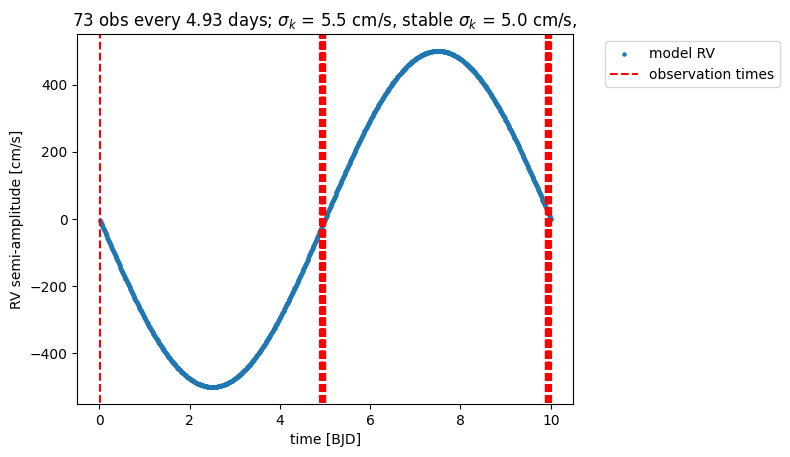

In [14]:
### strategy
cadence = 4.93
n_obs = 73

sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=n_obs, cadence=cadence, theta=test_theta, sigma_val=30)
print("FIM: ", fim)
print("sigma_k using linalg.inv: ", sigma_k)
print("sigma_k using linalg.solve: ", sigma_k_solve)
print("sigma_k using 1/sqrt(FIM_ii): ", sigma_k_stable)
      
### RV model
start = 2300 # BJD
end = 2400 # BJD
test_t = np.linspace(start, end, 1000) + np.random.normal(0, 1./24)
test_t_phase_folded = test_t % test_P
sigma_val = 30+1e-6 # cm/s
test_sigma = np.ones(len(test_t))*sigma_val
y = model(test_t, test_theta)
y_phase_folded = model(test_t_phase_folded, test_theta)

### plot observations from strategy
end = start + cadence * n_obs
strat = np.linspace(2300, end, n_obs) + np.random.normal(0, 1./24)
strat_phase_folded = strat % test_P

plt.scatter(test_t_phase_folded, y_phase_folded, s=5, label='model RV')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'{n_obs} obs every {cadence} days; ' + r'${\sigma}_k$' + f' = {np.round(sigma_k, 1)} cm/s, ' + r'stable ${\sigma}_k$' + f' = {np.round(sigma_k_stable, 1)} cm/s, ')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#plt.savefig('plots/strategy4.pdf', format='pdf')
plt.show()

In [15]:
np.unique(strat_phase_folded)

array([2.43207028e-03, 4.89395985e+00, 4.89701540e+00, 4.90007096e+00,
       4.90312651e+00, 4.90618207e+00, 4.90923763e+00, 4.91229318e+00,
       4.91534874e+00, 4.91840429e+00, 4.92145985e+00, 4.92451540e+00,
       4.92757096e+00, 4.93062651e+00, 4.93368207e+00, 4.93673763e+00,
       4.93979318e+00, 4.94284874e+00, 4.94590429e+00, 4.94895985e+00,
       4.95201540e+00, 4.95507096e+00, 4.95812651e+00, 4.96118207e+00,
       4.96423763e+00, 4.96729318e+00, 4.97034874e+00, 4.97340429e+00,
       4.97645985e+00, 4.97951540e+00, 4.98257096e+00, 4.98562651e+00,
       4.98868207e+00, 4.99173763e+00, 4.99479318e+00, 4.99784874e+00,
       5.00090429e+00, 9.89243207e+00, 9.89548763e+00, 9.89854318e+00,
       9.90159874e+00, 9.90465429e+00, 9.90770985e+00, 9.91076540e+00,
       9.91382096e+00, 9.91687651e+00, 9.91993207e+00, 9.92298763e+00,
       9.92604318e+00, 9.92909874e+00, 9.93215429e+00, 9.93520985e+00,
       9.93826540e+00, 9.94132096e+00, 9.94437651e+00, 9.94743207e+00,
      

### b) Marginalize over all start times

Add sensitivity maps for start times from 2300 to 2300 plus period of the planet

In [16]:
# priors
param_list = ['K','P','T0']
test_T0 = 2360 # BJD
test_K = 500 # 5 m/s to 500 cm/s; it worked for 10000 cm/s
test_P = 10 # days
test_theta = [test_K, test_P, test_T0]

dim = 100

### try different numbers of total observations made
n_observations = np.linspace(3, 102, dim).astype(int)

### try different observing cadences
### lower bound
# Arjun Savel (thanks, Arjun!) says that 0.6 days is generally considered the minimum (why?)
# Nyquist sampling says halve that to 0.3 days
# Nyquist sampling says the minimum number of observations you need to confirm periodicity is 2
# See wikipedia page for 'Nyquist rate'

### upper bound
# TESS planets generally have max period of 13.7 days
# again, due to Nyquist, halve it to 6.85 days
cadences = np.linspace(0.30, 6.85, dim)

#with tqdm.tqdm(total=100) as pbar:
starts = np.linspace(2300, 2300+test_P, 200)
sigma_ks_all = np.ones(dim**2).reshape((dim,dim))
sigma_ks_stable_all = np.ones(dim**2).reshape((dim,dim))
sigma_ks_solve_all = np.ones(dim**2).reshape((dim,dim))
    
for start in starts: 
    sigma_ks = np.ones(dim**2).reshape((dim,dim))
    sigma_ks_stable = np.ones(dim**2).reshape((dim,dim))
    sigma_ks_solve = np.ones(dim**2).reshape((dim,dim))

    for enum_i, i in enumerate(n_observations):
        for enum_j, j in enumerate(cadences):
            #print(i, j)
            try:
                sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=start, n_obs=i, cadence=j, theta=test_theta, sigma_val=30)
            except Exception as e:
                print(e, ", culprit: ", start, i, j)
            #print(sigma_k, sigma_k_stable)

            ### EDIT: as shown later, I needed to find out why some sigma_k's were blowing up
            ### Could it be aliasing, as suggested by the spacing of the yellow patches?
            ### Nope. Turns out, as shown directly below, that it's a numerical stability issue.
            ### To show this, I output an example FIM whose sigma_k term blows up.
            ### I compare its np.lingalg.inv() sigma_k against the one calculated by np.sqrt(1/FIM[0][0]).
            #if (enum_i==70 and enum_j==70):
            #    bad_fim = fim

            sigma_ks[enum_i][enum_j] = sigma_k
            sigma_ks_stable[enum_i][enum_j] = sigma_k_stable
            sigma_ks_solve[enum_i][enum_j] = sigma_k_solve

            sigma_ks_all += sigma_ks
            sigma_ks_stable_all += sigma_ks_stable
            sigma_ks_solve_all += sigma_ks_solve
            

/tmp/ipykernel_512569/3869568516.py:71: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_512569/3869568516.py:79: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


Singular matrix , culprit:  2300.1507537688444 60 4.997474747474747
Singular matrix , culprit:  2300.8040201005024 4 4.798989898989898
Singular matrix , culprit:  2301.005025125628 5 4.798989898989898
Singular matrix , culprit:  2301.407035175879 7 4.798989898989898
Singular matrix , culprit:  2301.608040201005 8 4.798989898989898
Singular matrix , culprit:  2301.809045226131 9 4.798989898989898
Singular matrix , culprit:  2302.4120603015076 12 4.798989898989898
Singular matrix , culprit:  2304.0201005025124 20 4.798989898989898
Singular matrix , culprit:  2304.422110552764 22 4.798989898989898
Singular matrix , culprit:  2304.974874371859 5 4.005050505050505
Singular matrix , culprit:  2305.175879396985 6 4.137373737373737
Singular matrix , culprit:  2305.6281407035176 28 4.798989898989898
Singular matrix , culprit:  2305.9798994974876 10 4.402020202020202
Singular matrix , culprit:  2306.2311557788944 31 4.798989898989898
Singular matrix , culprit:  2306.6331658291456 33 4.7989898989

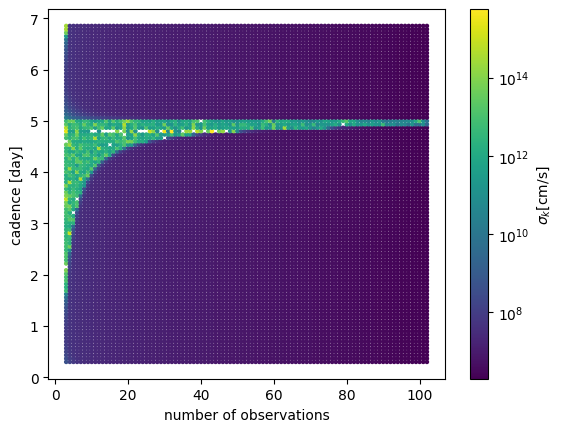

In [17]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks_all.T, s=5, norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$[cm/s]")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
#plt.savefig("plots/n_obs-cadence-sigma_k-stacked.pdf", format="pdf")
plt.show()

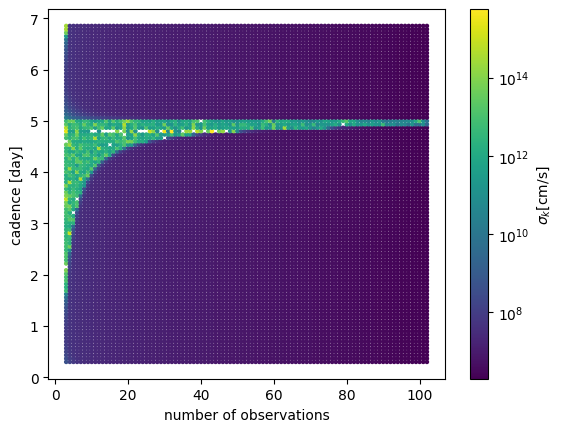

In [18]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks_solve_all.T, s=5, norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$[cm/s]")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
#plt.savefig("plots/n_obs-cadence-sigma_k-solve-stacked.pdf", format="pdf")
plt.show()

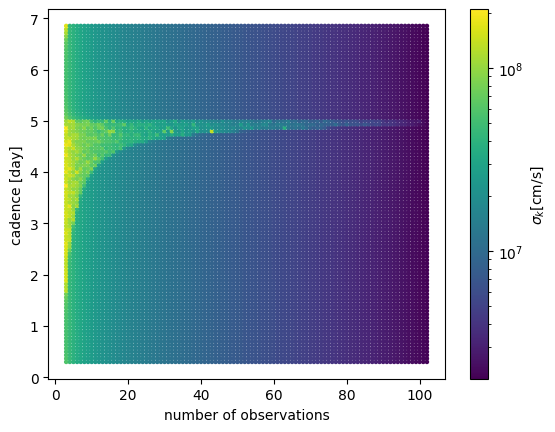

In [19]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks_stable_all.T, s=5, norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$[cm/s]")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
#plt.savefig("plots/n_obs-cadence-sigma_k-stable-stacked.pdf", format="pdf")
plt.show()

## Phase 2: Correlated Noise

Let's now add complexity to the covariance matrix, Sigma. Instead of it being just white noise (1/sigma_RV^2), it is now a quasi-periodic GP kernel, with free parameters given by the S-index part of Table 1 in Langellier et al 2020: https://iopscience.iop.org/article/10.3847/1538-3881/abf1e0/meta#ajabf1e0t1

In [5]:
### free parameters from Langellier et al 2020
# let's hold these constant for now, but maybe we should sample from the given uncertainties later?
Tau = 23.6 # active region lifetime; days
eta = 0.58 # smoothing parameter
Prot = 28.1 # solar rotation period; days
sigma_qp_s = 1.43e-3 # correlated noise amplitude
sigma_wn_s = 0.178e-3 # white noise amplitude

def cov_matrix(t, params):
    """
    Build a covariance matrix, Sigma, that will be used in the calculation of the Fisher Information Matrix
    
    Inputs:
    - t: time series of length N observations; np.array [day]
    - Tau: active region lifetime [days]; free param taken from Langellier et al 2020
    - eta: smoothing parameter; free param taken from Langellier et al 2020
    - Prot: rotation period [days]; free param taken from Langellier et al 2020
    - sigma_qp_s: correlated noise amplitude; free param taken from Langellier et al 2020
    - sigma_wn_s: white noise amplitude; free param taken from Langellier et al 2020
    
    Outputs:
    - N by N matrix of covariance elements following Equations 1 & 2 of Langellier et al 2020
    
    """
    
    Tau, eta, Prot, sigma_qp_s, sigma_wn_s = params[0], params[1], params[2], params[3], params[4]
    
    # create N by N matrix, where N is length of observations time series
    k = np.zeros((len(t),len(t)))
    
    for i in range(len(t)):
        for j in range(len(t)):
            term1 = ((t[i]-t[j])**2)/(2*Tau**2)
            term2 = (1/(2*eta**2)) * (np.sin(np.pi * (t[i] - t[j])/Prot))**2
            arg = -term1 - term2
            k[i][j] = np.exp(arg)
    
    K = sigma_qp_s**2 * k + sigma_wn_s**2 * np.diag(np.ones(len(t)))
    
    return K

params = [Tau, eta, Prot, sigma_qp_s, sigma_wn_s]
#cov_matrix(strat, params)

Recalculate FIM, replacing scalar sigma_RV with this new covariance matrix. 

In [22]:
# priors
param_list = ['K','P','T0']
test_T0 = 2360 # BJD
test_K = 500 # 5 m/s to 500 cm/s; it worked for 10000 cm/s
test_P = 10 # days
test_theta = [test_K, test_P, test_T0]

dim = 100

### try different numbers of total observations made
n_observations = np.linspace(3, 102, dim).astype(int)

### try different observing cadences
### lower bound
# Arjun Savel (thanks, Arjun!) says that 0.6 days is generally considered the minimum (why?)
# Nyquist sampling says halve that to 0.3 days
# Nyquist sampling says the minimum number of observations you need to confirm periodicity is 2
# See wikipedia page for 'Nyquist rate'

### upper bound
# TESS planets generally have max period of 13.7 days
# again, due to Nyquist, halve it to 6.85 days
cadences = np.linspace(0.30, 6.85, dim)
sigma_ks = np.ones(dim**2).reshape((dim,dim))
sigma_ks_stable = np.ones(dim**2).reshape((dim,dim))
sigma_ks_solve = np.ones(dim**2).reshape((dim,dim))

#with tqdm.tqdm(total=100) as pbar:
for enum_i, i in enumerate(n_observations):
    for enum_j, j in enumerate(cadences):
        #print(i, j)
        sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=i, cadence=j, theta=test_theta)

        sigma_ks[enum_i][enum_j] = sigma_k
        sigma_ks_stable[enum_i][enum_j] = sigma_k_stable
        sigma_ks_solve[enum_i][enum_j] = sigma_k_solve



/tmp/ipykernel_512569/3869568516.py:90: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_512569/3869568516.py:93: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


Plot sensitivity map

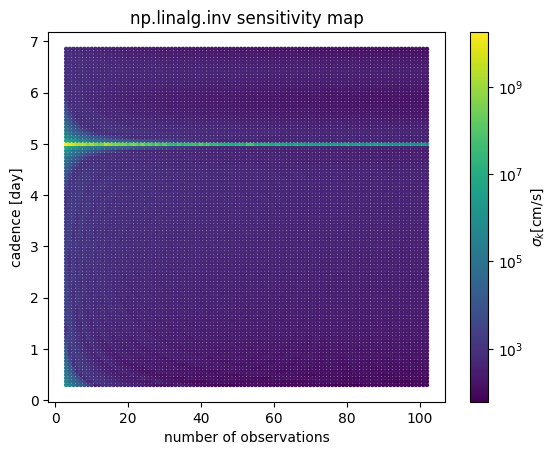

In [23]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks.T, s=5, norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$[cm/s]")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
plt.title("np.linalg.inv sensitivity map")
#plt.savefig("plots/sensivity-map-sigma_k-correlated.pdf", format="pdf")
plt.show()

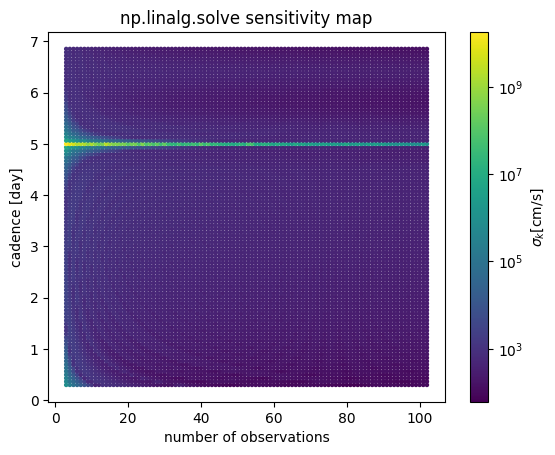

In [24]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks_solve.T, s=5, norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$[cm/s]")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
plt.title("np.linalg.solve sensitivity map")
#plt.savefig("plots/sensivity-map-sigma_k_solve-correlated.pdf", format="pdf")
plt.show()

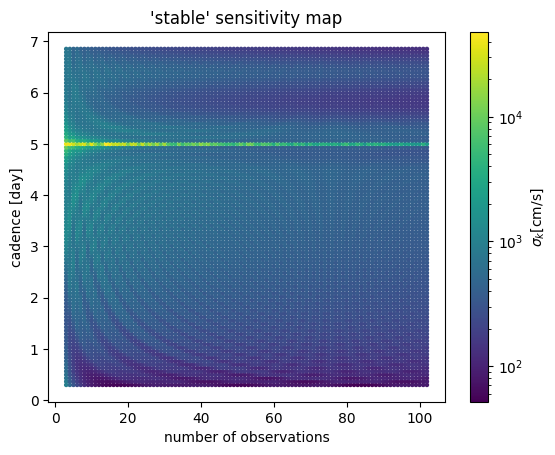

In [25]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks_stable.T, s=5, norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$[cm/s]")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
plt.title("'stable' sensitivity map")
#plt.savefig("plots/sensivity-map-sigma_k_stable-correlated.pdf", format="pdf")
plt.show()

Marginalize over different start times

In [ ]:
# priors
param_list = ['K','P','T0']
test_T0 = 2360 # BJD
test_K = 500 # 5 m/s to 500 cm/s; it worked for 10000 cm/s
test_P = 10 # days
test_theta = [test_K, test_P, test_T0]

dim = 100

### try different numbers of total observations made
n_observations = np.linspace(3, 102, dim).astype(int)

### try different observing cadences
### lower bound
# Arjun Savel (thanks, Arjun!) says that 0.6 days is generally considered the minimum (why?)
# Nyquist sampling says halve that to 0.3 days
# Nyquist sampling says the minimum number of observations you need to confirm periodicity is 2
# See wikipedia page for 'Nyquist rate'

### upper bound
# TESS planets generally have max period of 13.7 days
# again, due to Nyquist, halve it to 6.85 days
cadences = np.linspace(0.30, 6.85, dim)

#with tqdm.tqdm(total=100) as pbar:
starts = np.linspace(2300, 2300+test_P, 200)
sigma_ks_all_correlated = np.ones(dim**2).reshape((dim,dim))
sigma_ks_stable_all_correlated = np.ones(dim**2).reshape((dim,dim))
sigma_ks_solve_all_correlated = np.ones(dim**2).reshape((dim,dim))
    
for start in starts: 
    sigma_ks = np.ones(dim**2).reshape((dim,dim))
    sigma_ks_stable = np.ones(dim**2).reshape((dim,dim))
    sigma_ks_solve = np.ones(dim**2).reshape((dim,dim))

    for enum_i, i in enumerate(n_observations):
        for enum_j, j in enumerate(cadences):
            #print(i, j)
            try:
                sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=start, n_obs=i, cadence=j, theta=test_theta)
            except Exception as e:
                print(e, ", culprit: ", start, i, j)
            #print(sigma_k, sigma_k_stable)

            ### EDIT: as shown later, I needed to find out why some sigma_k's were blowing up
            ### Could it be aliasing, as suggested by the spacing of the yellow patches?
            ### Nope. Turns out, as shown directly below, that it's a numerical stability issue.
            ### To show this, I output an example FIM whose sigma_k term blows up.
            ### I compare its np.lingalg.inv() sigma_k against the one calculated by np.sqrt(1/FIM[0][0]).
            #if (enum_i==70 and enum_j==70):
            #    bad_fim = fim

            sigma_ks[enum_i][enum_j] = sigma_k
            sigma_ks_stable[enum_i][enum_j] = sigma_k_stable
            sigma_ks_solve[enum_i][enum_j] = sigma_k_solve

            sigma_ks_all_correlated += sigma_ks
            sigma_ks_stable_all_correlated += sigma_ks_stable
            sigma_ks_solve_all_correlated += sigma_ks_solve
            

/tmp/ipykernel_292003/1305888269.py:90: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_292003/1305888269.py:93: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


Singular matrix , culprit:  2300.0 15 4.666666666666666


#### Troubleshooting: dmu/dK as a function of n_obs

In [14]:
cadence = 6 # 4.93 #3 

sum_dmu_dK_array = []
sum_dmu_dK_first_elt_array = []
for n_obs in n_observations:
    #t = make_t(n_obs, cadence, start) 
    t = make_t_without_jitter(n_obs, cadence, start)
    test_theta = [test_K, test_P, test_T0]
    sigma = cov_matrix(t, params)
    sigma += 1e-6 

    dmu_dK = partial_mu(t, test_theta, 'K')
    sum_dmu_dK = np.sum(dmu_dK)
    sum_dmu_dK_first_elt = dmu_dK[0]
    sum_dmu_dK_array.append(sum_dmu_dK)
    sum_dmu_dK_first_elt_array.append(sum_dmu_dK_first_elt)
    
    #calculate_fim(t, sigma, test_theta)    


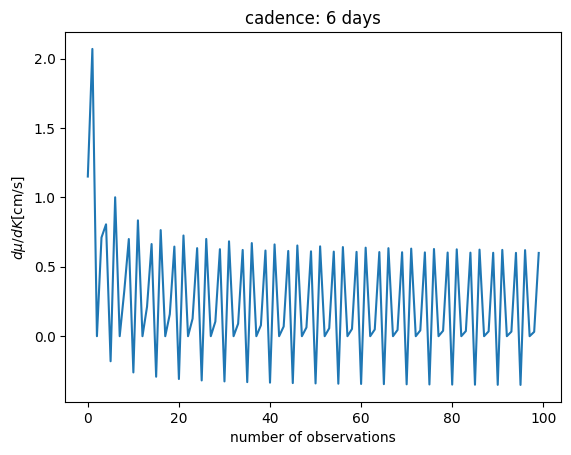

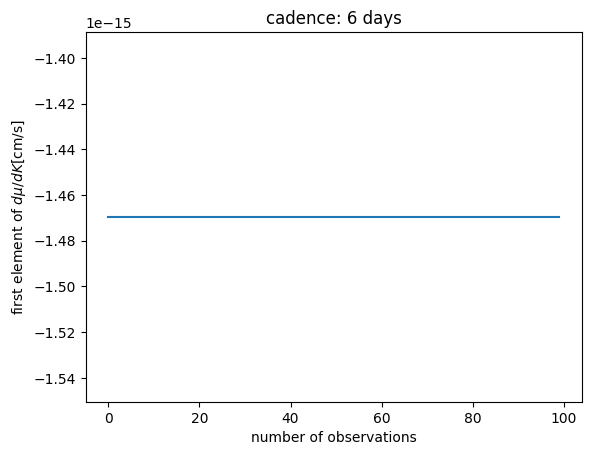

In [9]:
plt.plot(range(len(sum_dmu_dK_array)), sum_dmu_dK_array)
#plt.plot(range(len(sigma_k_stable_test)), sigma_k_stable_test, label='not using inv')
plt.xlabel('number of observations')
plt.ylabel(r"$d\mu / dK$[cm/s]")
plt.title(f"cadence: {cadence} days")
#plt.legend()
plt.show()

plt.plot(range(len(sum_dmu_dK_first_elt_array)), sum_dmu_dK_first_elt_array)
#plt.plot(range(len(sigma_k_stable_test)), sigma_k_stable_test, label='not using inv')
plt.xlabel('number of observations')
plt.ylabel(r"first element of $d\mu / dK$[cm/s]")
plt.title(f"cadence: {cadence} days")
#plt.legend()
plt.show()

#### Cadence vs Period vs sigma_k/Fisher Information

Let's reproduce Arvind Gupta's plot, for P in {1, 400 days} (although we'll be interested only up to ~30 days) and cadence in {0, 7 days}.

In [35]:
sigma_ks

array([[9.36979039e+05, 5.59807144e+05, 3.06851077e+05, ...,
        8.02899619e+02, 8.16558354e+02, 8.16291948e+02],
       [2.71359353e+05, 1.13366668e+05, 7.59473876e+04, ...,
        8.27140233e+02, 8.13357270e+02, 7.95548399e+02],
       [9.33081422e+04, 4.73912983e+04, 2.18831038e+04, ...,
        6.30984523e+02, 5.83171141e+02, 5.40704945e+02],
       ...,
       [9.56304403e+01, 9.58801919e+01, 1.06432410e+02, ...,
        1.84572603e+02, 1.54729269e+02, 1.33971386e+02],
       [9.96970506e+01, 9.87959378e+01, 1.01656577e+02, ...,
        1.80292782e+02, 1.54845254e+02, 1.34608671e+02],
       [1.03181943e+02, 9.90416285e+01, 9.46302185e+01, ...,
        1.81010846e+02, 1.55166405e+02, 1.32442597e+02]])

In [15]:
np.log10(cond(sigma_ks))

13.862002014947597

In [ ]:
start = 2300
dim = 100
cadences = np.linspace(0.30, 6.85, dim)
periods = np.linspace(1, 400, 400)
n_obs = 500 #40

sigma_k_test = []
sigma_k_solve_test = []
sigma_k_stable_test = []
fi_k_test = []

sigma_ks = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))
sigma_ks_stable = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))
sigma_ks_solve = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))
fi_ks = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))


for enum_p, p in enumerate(tqdm(periods)):
    for enum_c, c in enumerate(cadences):
        
        test_theta = [test_K, p, test_T0]
        sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=start, n_obs=n_obs, cadence=c, theta=test_theta)
        
        fi_k = fim[0][0]
        inv_fim = inv(fim)
        sigma_k = np.sqrt(inv_fim)[0][0]
        sigma_k_stable = np.sqrt(1/fim[0][0])
        inv_fim_solve = solve(fim, np.diag(np.ones(len(test_theta)))) 
        sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]
        
        # for 1D plots and testing
        sigma_k_test.append(sigma_k)
        sigma_k_solve_test.append(sigma_k_solve)
        sigma_k_stable_test.append(sigma_k_stable)

        fi_k_test.append(fi_k)
        
        # for 2D plots and testing
        sigma_ks[enum_p][enum_c] = sigma_k
        sigma_ks_stable[enum_p][enum_c] = sigma_k_stable
        sigma_ks_solve[enum_p][enum_c] = sigma_k_solve
        
        fi_ks[enum_p][enum_c] = fi_k
        

  0%|          | 0/400 [00:00<?, ?it/s]/tmp/ipykernel_1268561/100179410.py:111: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_1268561/100179410.py:114: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]
/tmp/ipykernel_1268561/3578527295.py:26: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_1268561/3578527295.py:29: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]
  0%|          | 1/400 [02:20<15:36:35, 140.84s/it]

In [ ]:
x, y = np.meshgrid(cadences, periods)
plt.scatter(x, y, c=sigma_ks, s=5, norm=matplotlib.colors.LogNorm(vmax=1e3)) # vmin=1e5, vmax=1e10
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"log $\sigma_k$[cm/s]")
plt.xlabel("cadence [day]")
plt.ylabel("period [day]")
plt.title(f"{n_obs} observations")
plt.savefig("plots/cadence_v_period_sigma_k_500.pdf", format="pdf")
plt.show()

In [ ]:
x, y = np.meshgrid(cadences, periods)
plt.scatter(x, y, c=fi_ks, s=5, norm=matplotlib.colors.LogNorm()) # vmin=1e5, vmax=1e10
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"Fisher Information on K")
plt.xlabel("cadence [day]")
plt.ylabel("period [day]")
plt.title(f"{n_obs} observations")
plt.savefig("plots/cadence_v_period_fi_500.pdf", format="pdf")
plt.show()

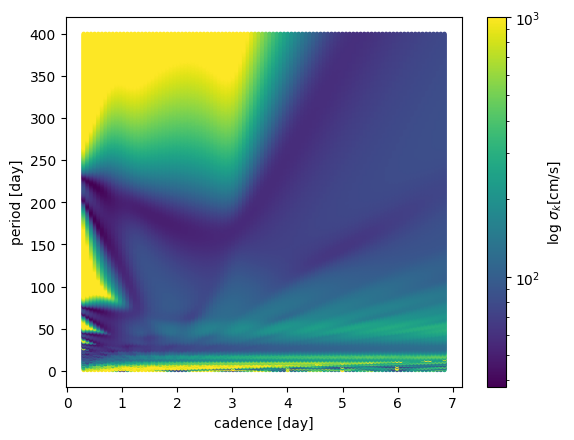

In [24]:
x, y = np.meshgrid(cadences, periods)
plt.scatter(x, y, c=sigma_ks, s=5, norm=matplotlib.colors.LogNorm(vmax=1e3)) # vmin=1e5, vmax=1e10
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"log $\sigma_k$[cm/s]")
plt.xlabel("cadence [day]")
plt.ylabel("period [day]")
plt.savefig("plots/cadence_v_period_sigma_k.pdf", format="pdf")
plt.show()

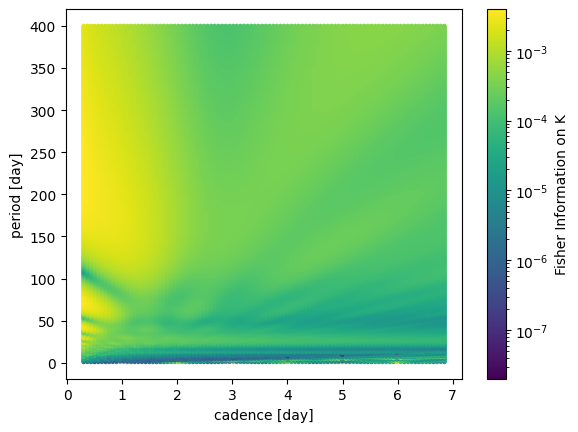

In [26]:
x, y = np.meshgrid(cadences, periods)
plt.scatter(x, y, c=fi_ks, s=5, norm=matplotlib.colors.LogNorm()) # vmin=1e5, vmax=1e10
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"Fisher Information on K")
plt.xlabel("cadence [day]")
plt.ylabel("period [day]")
plt.savefig("plots/cadence_v_period_fi.pdf", format="pdf")
plt.show()

In [21]:
start = 2300
dim = 100
cadences = np.linspace(0.30, 6.85, dim)
periods = np.linspace(1, 400, 400)
n_obs = 40

sigma_k_test = []
sigma_k_solve_test = []
sigma_k_stable_test = []
fi_k_test = []

sigma_ks = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))
sigma_ks_stable = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))
sigma_ks_solve = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))
fi_ks = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))

for enum_p, p in enumerate(periods):
    for enum_c, c in enumerate(cadences):
        
        test_theta = [test_K, p, test_T0]
        sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=start, n_obs=n_obs, cadence=c, theta=test_theta)
        
        fi_k = fim[0][0]
        #print(p, c, sigma_k, fi_k)
        
        # for 1D plots and testing
        sigma_k_test.append(sigma_k)
        sigma_k_solve_test.append(sigma_k_solve)
        sigma_k_stable_test.append(sigma_k_stable)

        fi_k_test.append(fi_k)
        
        # for 2D plots and testing
        sigma_ks[enum_p][enum_c] = sigma_k
        sigma_ks_stable[enum_p][enum_c] = sigma_k_stable
        sigma_ks_solve[enum_p][enum_c] = sigma_k_solve
        
        fi_ks[enum_p][enum_c] = fi_k

/tmp/ipykernel_771427/100179410.py:111: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_771427/100179410.py:114: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


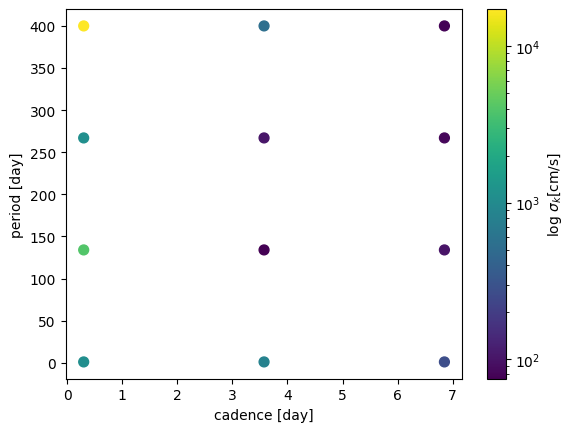

In [19]:
x, y = np.meshgrid(cadences, periods)
plt.scatter(x, y, c=sigma_ks, s=50, norm=matplotlib.colors.LogNorm()) # vmin=1e5, vmax=1e10
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"log $\sigma_k$[cm/s]")
plt.xlabel("cadence [day]")
plt.ylabel("period [day]")
#plt.savefig("plots/n_obs-cadence-sigma_k-correlated.pdf", format="pdf")
plt.show()

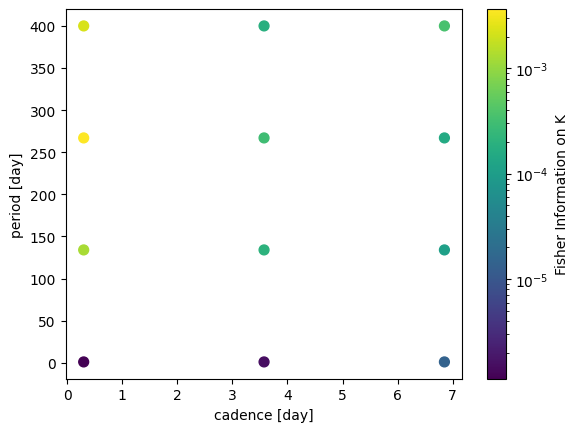

In [18]:
x, y = np.meshgrid(cadences, periods)
plt.scatter(x, y, c=fi_ks, s=50, norm=matplotlib.colors.LogNorm()) # vmin=1e5, vmax=1e10
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"Fisher Information on K")
plt.xlabel("cadence [day]")
plt.ylabel("period [day]")
#plt.savefig("plots/n_obs-cadence-sigma_k-correlated.pdf", format="pdf")
plt.show()